In [1]:
#|default_exp app

In [2]:
#| export
from fastai.tabular.all import *
from fastbook import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error

import seaborn as sns

from dtreeviz.trees import *
import dtreeviz

from treeinterpreter import treeinterpreter as ti
import waterfall_chart

from fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import force_console_behavior


In [3]:
master_bar, progress_bar = force_console_behavior()

In [4]:
#| export
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
creds = ''

In [5]:
#| export
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [6]:
#| export
path = Path('store-sales-time-series-forecasting')

In [7]:
#| export
if not iskaggle and not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))    
    zipfile.ZipFile(f'{path}.zip').extractall(path)


In [8]:
#| export
if iskaggle:
    path = Path('../input/store-sales-time-series-forecasting')
    ! pip install -q dataset

Import CSVs as dataframes

In [9]:
#| export
train_df = pd.read_csv(path/'train.csv', low_memory=False)
test_df = pd.read_csv(path/'test.csv', low_memory=False)
sub_df = pd.read_csv(path/'sample_submission.csv', low_memory=False)
stores_df = pd.read_csv(path/'stores.csv', low_memory=False)
oil_df = pd.read_csv(path/'oil.csv', low_memory=False)
hol_events_df = pd.read_csv(path/'holidays_events.csv', low_memory=False)
transactions_df = pd.read_csv(path/'transactions.csv', low_memory=False)

Combine training and test set for parrallel data transforms - to be split later before training

In [10]:
#| export
combined_df = pd.concat([train_df, test_df]).reset_index()

Create `test_indexes` to split the dataframe later

In [11]:
#| export
test_idxs = combined_df.index[(combined_df.index > train_df.index.max())] 

Create Index values for training and validation sets

In [12]:
#| export
train_idxs = combined_df.index[(combined_df.index < round(len(train_df) * 0.8))]

In [13]:
#| export
valid_idxs = combined_df.index[(combined_df.index > len(train_idxs)) & (combined_df.index < test_idxs.min())]

Merge Oil Prices

In [14]:
#| export
combined_df = combined_df.merge(oil_df, on='date', how='left')

Merge Store Metadata

In [15]:
#| export
combined_df = combined_df.merge(stores_df, on='store_nbr', how='left')

Rename `type` column and Merge Observed Holidays

In [16]:
#| export
hol_events_df.rename(columns={'type': 'hol_type'}, inplace=True)

In [17]:
# | export
# combined_df = combined_df.merge(hol_events_df, on='date', how='left')

Convert `date` to datetime

In [18]:
#| export
combined_df['date'] = pd.to_datetime(combined_df['date'])

Block out a month for data affected by earthquake

In [19]:
#| export
eq_start_date = pd.to_datetime("2016-04-16")
eq_end_date = pd.to_datetime("2016-05-16")

In [20]:
#| export
earthquake_cond = (combined_df.date >= eq_start_date) & (combined_df.date < eq_end_date)

Get indexes of items at earthquake dates - to be removed or transformed depending on model performance

In [21]:
#| export
earthquake_indexes = combined_df.index[earthquake_cond]

Convert `date` to mulitple date partition columns

In [22]:
#| export
combined_df = add_datepart(combined_df, 'date')

Drop rows at earthquake timeframe

In [23]:
# #| export
# combined_df.drop(earthquake_indexes, inplace=True)

Set dependant variable

In [24]:
#| export
dep_var = 'sales'

Convert the `sales` column to a logarithm value

In [25]:
#| export
combined_df[dep_var] = np.log(combined_df[dep_var] + 1e-5)

Set processes

In [26]:
#| export
procs = [Categorify, FillMissing, Normalize]

Let fastai split continuous and categorical variables with a max cardinality of 1

In [27]:
#| export
cont, cat = cont_cat_split(combined_df, 1, dep_var=dep_var)

Specify the the training and validation set indexes

In [28]:
#| export
train_val_splits = (list(train_idxs), list(valid_idxs))

Create `TabularPandas` object for training, validation, and test

In [29]:
#| export
to = TabularPandas(combined_df, procs, cat, cont, y_names=dep_var, splits=train_val_splits)

In [30]:
#| export
test_to = TabularPandas(combined_df.iloc[test_idxs], procs, cat, cont, y_names=None, splits=None)

Assign training and validation x's and y's to save some typing in the future

In [31]:
#| export
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [32]:
test_xs = test_to.train.xs

Create functions to compute *mean square error* on a given model

In [33]:
#| export
def r_mse(pred, y):
    return round(math.sqrt(((pred-y)**2).mean()), 6)

In [34]:
#| export
def m_rmse(m, xs, y):
    return r_mse(m.predict(xs), y)

Create definition to quickly call `RandomForestRegressor` variations

In [35]:
#| export
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, 
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

Fit a model

In [36]:
#| export
m = rf(xs, y)

Check score on training and validation sets

In [37]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(2.183198, 2.992358)

Check the impact of `n_estimators`

In [38]:
preds = np.stack([t.predict(valid_xs.values) for t in m.estimators_])

`preds.mean(0)` should give the same result as the random forest validation set

In [39]:
r_mse(preds.mean(0), valid_y)

2.992358

Plot the effect of increasing `n_estimators`

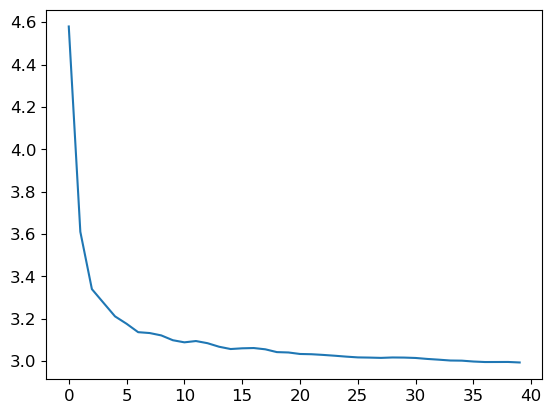

In [40]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

Check OOB error

In [41]:
r_mse(m.oob_prediction_, y)

2.252802

Check *feature importance*

In [42]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending=False) 

In [43]:
fi = rf_feat_importance(m, xs)

In [44]:
fi

,cols,imp
0,family,4.836593e-01
14,onpromotion,1.337347e-01
13,store_nbr,1.067480e-01
12,id,4.507540e-02
11,index,4.457210e-02
3,type,3.187712e-02
16,cluster,2.921448e-02
1,city,2.754661e-02
2,state,2.459213e-02
23,Elapsed,2.027386e-02


In [45]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

<AxesSubplot: ylabel='cols'>

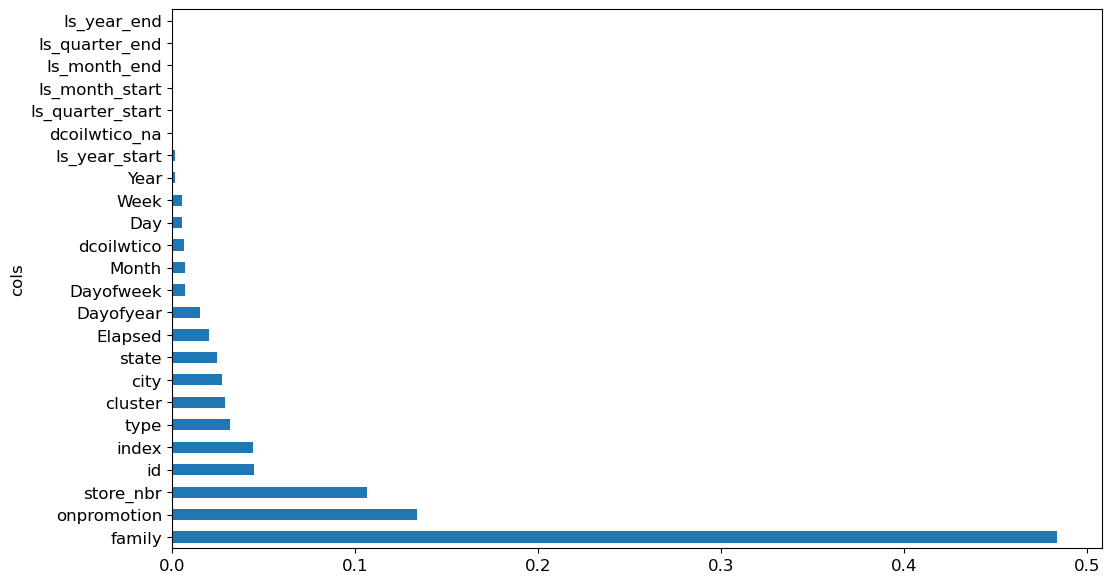

In [46]:
plot_fi(fi)

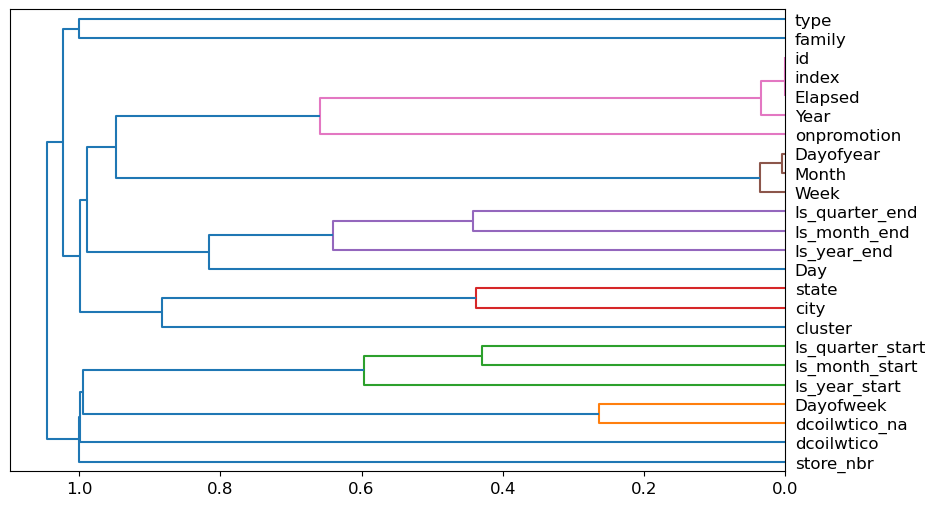

In [47]:
cluster_columns(xs)

Create a function to return OOB score, with 0 being completely random, and 1 being a perfect model

In [48]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15, 
                              max_samples=50000, max_features=0.5, 
                              n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [49]:
get_oob(xs)

0.8481933209216589

#### Create Tabular Learner

In [50]:
#| export
dls = to.dataloaders(1024)

In [51]:
y = to.train.y

In [52]:
y.min(), y.max()

(-11.512925, 11.733803)

In [53]:
#| export
learn = tabular_learner(dls, layers=[500, 250], n_out=1, y_range=(-11,11), loss_func=F.mse_loss)

SuggestedLRs(valley=0.0005754399462603033)

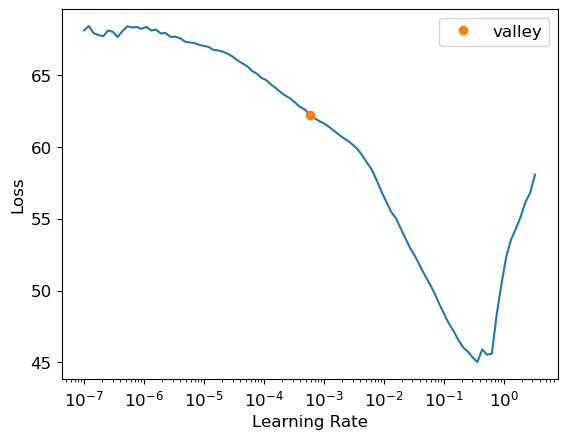

In [54]:
learn.lr_find()

In [55]:
#| export
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time


In [56]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

3.071158

In [57]:
rf_preds = m.predict(valid_xs)

In [58]:
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [59]:
r_mse(ens_preds, valid_y)

2.89106

In [60]:
rf_test_preds = m.predict(test_xs)

In [61]:
dl = learn.dls.test_dl(combined_df.iloc[test_idxs])

In [62]:
preds = learn.get_preds(dl=dl)

In [63]:
# preds_norm = np.exp(preds[0] + 1e-5)

In [64]:
# rf_preds_norm = np.exp(rf_test_preds + 1e-5)

In [87]:
np_preds = to_np(preds[0]).reshape(-1)

Get ensemble prediction using Random Forest and Neural Network

In [88]:
ens_preds = (np_preds + rf_test_preds) / 2

In [89]:
ens_preds.shape

(28512,)

In [68]:
learn.save('nn2')

Path('models/nn2.pth')

In [90]:
ens_preds

array([ -0.37311011, -10.57738989,  -0.33711898, ...,   6.27678137,   2.872789  ,   1.97650182])

In [91]:
ens_preds_norm = np.exp(ens_preds + 1e-5)

In [92]:
ens_preds_norm

array([6.88596296e-01, 2.54860353e-05, 7.13831039e-01, ..., 5.32078680e+02, 1.76864533e+01, 7.21752303e+00])

In [95]:
sub_df['sales'] = ens_preds_norm

In [96]:
sub_df.head()

,id,sales
0,3000888,0.688596
1,3000889,0.000025
2,3000890,0.713831
3,3000891,1570.957692
4,3000892,0.000015


In [97]:
sub_df.shape

(28512, 2)

In [98]:
sub_df.to_csv('submission.csv', index=False)

In [99]:
import nbdev
nbdev.export.nb_export('store_sales_2.ipynb', 'app')
print('export successful')

export successful
